In [ ]:
!pip install timm

# Notebook Overview

This notebook demonstrates how to extract depth maps from images using the MiDaS model and convert selected 2D pixel coordinates to 3D coordinates.

## Setup

The notebook starts by installing the necessary libraries: `timm` and `ultralytics`.

## MiDaS Model

The code loads the MiDaS model (`DPT_Large` by default) and sets it up for inference on either a CUDA-enabled GPU or the CPU. It also loads the appropriate transformation for the chosen model.

## Google Drive Mounting

The notebook mounts Google Drive to access images and save output depth maps.

## Depth Extraction for a Single Image

A single image (`frame_11.jpg`) is loaded, transformed, and processed by the MiDaS model to generate a depth map. The depth map is then visualized.

Individual depth values at specific pixel locations are extracted and printed.

## 2D to 3D Conversion

A function `get_3d` is defined to convert 2D pixel coordinates and their corresponding depth values to 3D coordinates using estimated camera intrinsic parameters (`fx`, `fy`, `cx`, `cy`).

Estimated focal lengths (`fx` and `fy`) are calculated based on image dimensions and field of view.

The `get_3d` function is applied to a list of selected pixel coordinates and their extracted depth values to obtain their 3D representations. These 3D points are then printed.

## Batch Depth Extraction

A function `extract_depth_from_folder` is defined to process all images in a specified input folder, extract their depth maps using MiDaS, and save the depth maps as `.npy` files in an output folder.

This function is then called to extract depth maps from a folder on Google Drive and save them to another folder on Google Drive.

A depth value from one of the extracted depth maps in the batch is accessed and printed as an example.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00


In [ ]:
import cv2
import torch

import matplotlib.pyplot as plt
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:17<00:00, 77.2MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
depth_value = output[692, 967]
print(depth_value)


5.147426


In [ ]:
x1_src, y1_src=1466,216
x2_src, y2_src=973,419
x3_src, y3_src=477,458
x4_src, y4_src=281,352
x5_src, y5_src=453,398
x6_src, y6_src=1066,271
x7_src, y7_src=495,544
x8_src, y8_src=1128,461

x9_src, y9_src=1790,498
x10_src, y10_src=593,619


In [ ]:
# Example: list of pixel coordinates where you want to extract depth
selected_pixels = [(x1_src,y1_src),(x2_src,y2_src),(x3_src, y3_src),(x4_src, y4_src),(x5_src, y5_src),(x6_src, y6_src),(x7_src, y7_src),(x8_src, y8_src),(x9_src, y9_src),(x10_src, y10_src)]

# Extract depth values at those pixel locations
depth_values = [output[y, x] for (x, y) in selected_pixels]

print("Selected Depth Values:", depth_values)


Selected Depth Values: [np.float32(6.0646777), np.float32(5.631296), np.float32(5.219418), np.float32(8.631398), np.float32(5.7363935), np.float32(5.517457), np.float32(8.140588), np.float32(6.174434), np.float32(9.40432), np.float32(5.8704553)]


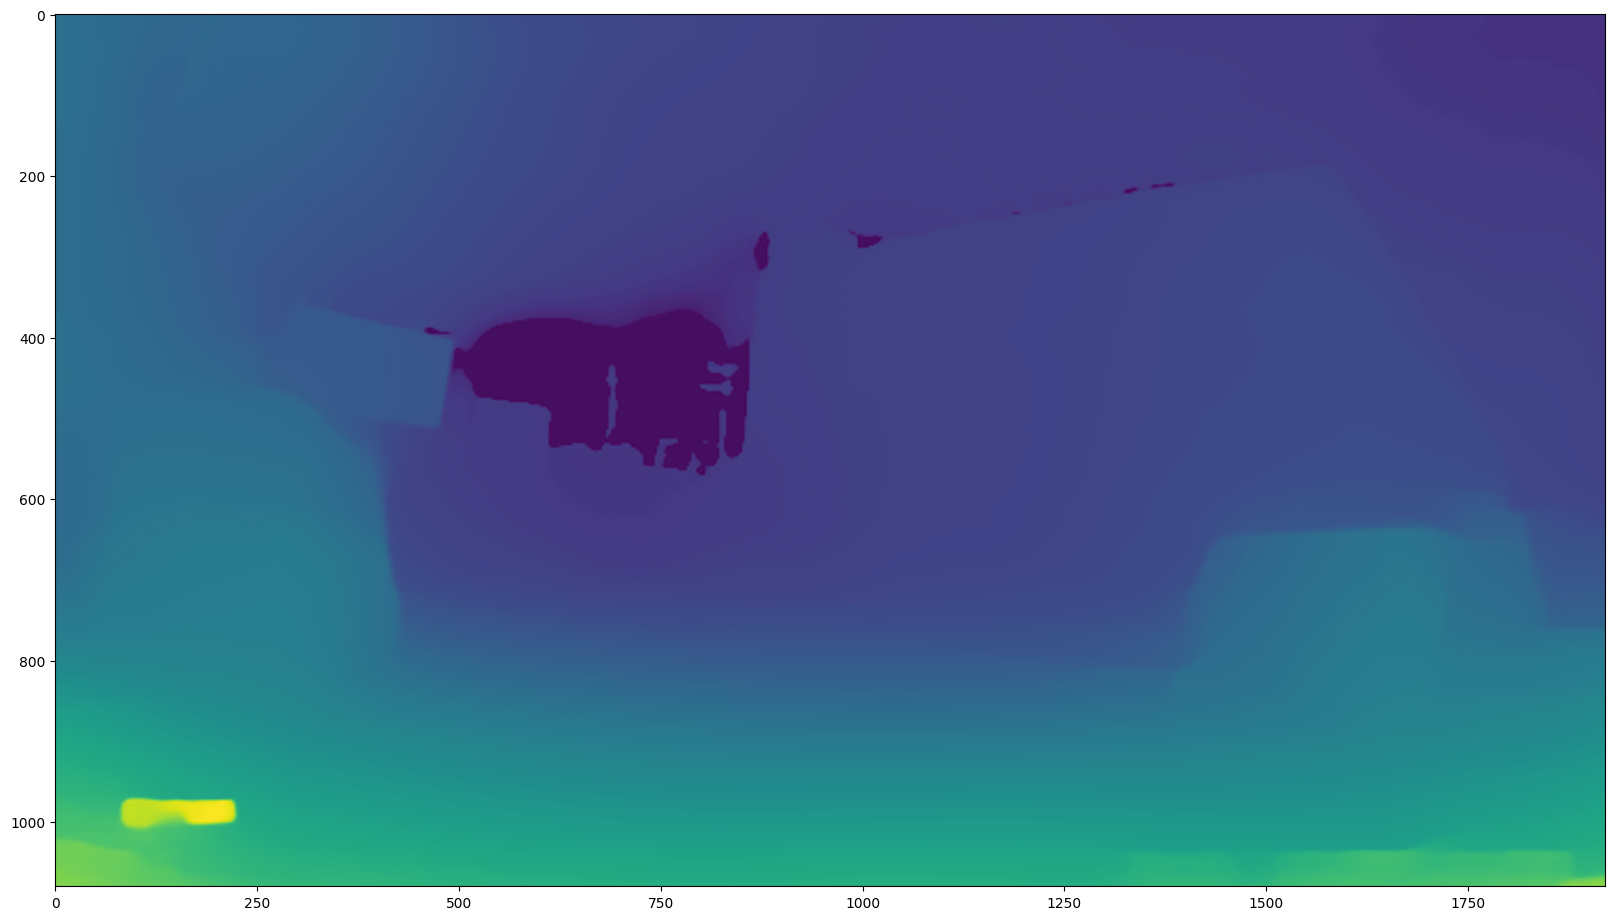

In [ ]:
img = cv2.imread("/content/frame_11.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()
plt.figure(figsize=(20,20))
plt.imshow(output)


In [ ]:
output[674,597]


np.float32(6.930965)

In [ ]:
output[127,625]

np.float32(8.092331)

In [ ]:
output[965,694]

np.float32(20.626472)

In [ ]:
output[694,965]

np.float32(7.184154)

In [ ]:
output[743,1552]

np.float32(15.360687)

In [ ]:
def get_3d(x,y,z,fx=554.256,fy=554.3255055924296,cx=960,cy=540):
  X=(x-cx)*z/fx
  Y=(y-cy)*z/fy
  return X,Y,z


In [ ]:
points_3d = [get_3d(x, y, z) for (x, y), z in zip(selected_pixels, depth_values)]

NameError: name 'selected_pixels' is not defined

In [ ]:
for point in points_3d:
  print(point)

(np.float32(5.5366597), np.float32(-3.5447686), np.float32(6.0646777))
(np.float32(0.1320813), np.float32(-1.2292179), np.float32(5.631296))
(np.float32(-4.548402), np.float32(-0.7720956), np.float32(5.219418))
(np.float32(-10.57403), np.float32(-2.9273467), np.float32(8.631398))
(np.float32(-5.2473073), np.float32(-1.4694757), np.float32(5.7363935))
(np.float32(1.0551991), np.float32(-2.677481), np.float32(5.517457))
(np.float32(-6.829648), np.float32(0.058742292), np.float32(8.140588))
(np.float32(1.8715268), np.float32(-0.87995285), np.float32(6.174434))
(np.float32(14.082997), np.float32(-0.71254426), np.float32(9.40432))
(np.float32(-3.8871155), np.float32(0.8366311), np.float32(5.8704553))


In [ ]:
x1_src,y1_src=5.5366597,-3.5447686
x2_src,y2_src=0.1320813,-1.2292179
x3_src,y3_src=-4.548402,-0.7720956
x4_src,y4_src=-10.57403,-2.9273467
x5_src,y5_src=-5.2473073,-1.4694757
x6_src,y6_src=1.0551991,-2.677481
x7_src,y7_src=-6.829648,0.058742292
x8_src,y8_src=1.8715268,-0.87995285
x9_src,y9_src=14.082997,-0.71254426
x10_src,y10_src=-3.8871155,0.8366311


In [ ]:
import numpy as np

image_width = 1920
image_height = 1080
hfov = 120
vfov = 88.5

fx = image_width / (2 * np.tan(np.radians(hfov / 2)))
fy = image_height / (2 * np.tan(np.radians(vfov / 2)))

print(f"Estimated fx: {fx}, Estimated fy: {fy}")


Estimated fx: 554.2562584220409, Estimated fy: 554.3255055924296


In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

def extract_depth_from_folder(input_folder, output_folder, model_type="DPT_Large"):
    """
    Extracts depth maps for all images in a folder using MiDaS and saves them as .npy files.

    Args:
        input_folder (str): Path to folder containing input images.
        output_folder (str): Path to save output .npy depth maps.
        model_type (str): MiDaS model to use. Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    """
    os.makedirs(output_folder, exist_ok=True)

    # Load model
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type in ["DPT_Large", "DPT_Hybrid"]:
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    # List image files
    image_files = sorted([
        f for f in os.listdir(input_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
    ])
    main_out=[]
    # Process each image
    for img_file in tqdm(image_files, desc="Extracting depth maps"):
        img_path = os.path.join(input_folder, img_file)
        print(img_path)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Skipping unreadable image {img_file}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        input_batch = transform(img).to(device)

        with torch.no_grad():
            prediction = midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        depth_map = prediction.cpu().numpy()
        base_name = os.path.splitext(img_file)[0]
        np.save(os.path.join(output_folder, f"{base_name}.npy"), depth_map)
        main_out.append(depth_map)

        # # Save depth map
        # output_path = os.path.join(output_folder, base_name + ".npy")
        # np.save(output_path, depth_map)
    print(f"Saved {len(image_files)} depth maps to {output_folder}")
    return main_out
out=extract_depth_from_folder(input_folder="/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam",output_folder="/content/drive/MyDrive/MainDataihub/Depthmaps")


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Extracting depth maps:   0%|          | 0/192 [00:00<?, ?it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0001.jpg


Extracting depth maps:   1%|          | 1/192 [00:00<01:13,  2.61it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0002.jpg


Extracting depth maps:   1%|          | 2/192 [00:00<01:18,  2.43it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0003.jpg


Extracting depth maps:   2%|▏         | 3/192 [00:01<01:12,  2.60it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0004.jpg


Extracting depth maps:   2%|▏         | 4/192 [00:01<01:09,  2.72it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0005.jpg


Extracting depth maps:   3%|▎         | 5/192 [00:01<01:07,  2.78it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0006.jpg


Extracting depth maps:   3%|▎         | 6/192 [00:02<01:05,  2.82it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0007.jpg


Extracting depth maps:   4%|▎         | 7/192 [00:02<01:05,  2.84it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0008.jpg


Extracting depth maps:   4%|▍         | 8/192 [00:02<01:03,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0009.jpg


Extracting depth maps:   5%|▍         | 9/192 [00:03<01:02,  2.91it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0010.jpg


Extracting depth maps:   5%|▌         | 10/192 [00:03<01:03,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0011.jpg


Extracting depth maps:   6%|▌         | 11/192 [00:03<01:02,  2.90it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0012.jpg


Extracting depth maps:   6%|▋         | 12/192 [00:04<01:01,  2.94it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0013.jpg


Extracting depth maps:   7%|▋         | 13/192 [00:04<01:16,  2.35it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0014.jpg


Extracting depth maps:   7%|▋         | 14/192 [00:05<01:14,  2.40it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0015.jpg


Extracting depth maps:   8%|▊         | 15/192 [00:05<01:11,  2.49it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0016.jpg


Extracting depth maps:   8%|▊         | 16/192 [00:06<01:13,  2.39it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0017.jpg


Extracting depth maps:   9%|▉         | 17/192 [00:06<01:09,  2.53it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0018.jpg


Extracting depth maps:   9%|▉         | 18/192 [00:06<01:06,  2.61it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0019.jpg


Extracting depth maps:  10%|▉         | 19/192 [00:07<01:08,  2.53it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0020.jpg


Extracting depth maps:  10%|█         | 20/192 [00:07<01:04,  2.65it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0021.jpg


Extracting depth maps:  11%|█         | 21/192 [00:07<01:02,  2.72it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0022.jpg


Extracting depth maps:  11%|█▏        | 22/192 [00:08<01:01,  2.77it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0023.jpg


Extracting depth maps:  12%|█▏        | 23/192 [00:08<01:10,  2.41it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0024.jpg


Extracting depth maps:  12%|█▎        | 24/192 [00:09<01:05,  2.56it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0025.jpg


Extracting depth maps:  13%|█▎        | 25/192 [00:09<01:03,  2.61it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0026.jpg


Extracting depth maps:  14%|█▎        | 26/192 [00:09<01:02,  2.65it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0027.jpg


Extracting depth maps:  14%|█▍        | 27/192 [00:10<01:01,  2.70it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0028.jpg


Extracting depth maps:  15%|█▍        | 28/192 [00:10<01:02,  2.63it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0029.jpg


Extracting depth maps:  15%|█▌        | 29/192 [00:11<01:04,  2.51it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0030.jpg


Extracting depth maps:  16%|█▌        | 30/192 [00:11<01:03,  2.55it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0031.jpg


Extracting depth maps:  16%|█▌        | 31/192 [00:11<01:03,  2.53it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0032.jpg


Extracting depth maps:  17%|█▋        | 32/192 [00:12<01:02,  2.54it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0033.jpg


Extracting depth maps:  17%|█▋        | 33/192 [00:12<01:01,  2.58it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0034.jpg


Extracting depth maps:  18%|█▊        | 34/192 [00:13<01:03,  2.47it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0035.jpg


Extracting depth maps:  18%|█▊        | 35/192 [00:13<01:00,  2.59it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0036.jpg


Extracting depth maps:  19%|█▉        | 36/192 [00:13<00:59,  2.62it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0037.jpg


Extracting depth maps:  19%|█▉        | 37/192 [00:14<00:57,  2.70it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0038.jpg


Extracting depth maps:  20%|█▉        | 38/192 [00:14<00:56,  2.75it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0039.jpg


Extracting depth maps:  20%|██        | 39/192 [00:14<01:04,  2.38it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0040.jpg


Extracting depth maps:  21%|██        | 40/192 [00:15<01:01,  2.49it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0041.jpg


Extracting depth maps:  21%|██▏       | 41/192 [00:15<00:57,  2.61it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0042.jpg


Extracting depth maps:  22%|██▏       | 42/192 [00:16<00:56,  2.64it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0043.jpg


Extracting depth maps:  22%|██▏       | 43/192 [00:16<00:54,  2.71it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0044.jpg


Extracting depth maps:  23%|██▎       | 44/192 [00:16<00:54,  2.73it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0045.jpg


Extracting depth maps:  23%|██▎       | 45/192 [00:17<00:52,  2.77it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0046.jpg


Extracting depth maps:  24%|██▍       | 46/192 [00:17<00:52,  2.77it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0047.jpg


Extracting depth maps:  24%|██▍       | 47/192 [00:17<00:57,  2.50it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0048.jpg


Extracting depth maps:  25%|██▌       | 48/192 [00:18<00:54,  2.62it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0049.jpg


Extracting depth maps:  26%|██▌       | 49/192 [00:18<00:53,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0050.jpg


Extracting depth maps:  26%|██▌       | 50/192 [00:19<00:52,  2.70it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0051.jpg


Extracting depth maps:  27%|██▋       | 51/192 [00:19<00:51,  2.75it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0052.jpg


Extracting depth maps:  27%|██▋       | 52/192 [00:19<00:50,  2.78it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0053.jpg


Extracting depth maps:  28%|██▊       | 53/192 [00:20<00:50,  2.78it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0054.jpg


Extracting depth maps:  28%|██▊       | 54/192 [00:20<00:48,  2.82it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0055.jpg


Extracting depth maps:  29%|██▊       | 55/192 [00:20<00:48,  2.81it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0056.jpg


Extracting depth maps:  29%|██▉       | 56/192 [00:21<00:49,  2.75it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0057.jpg


Extracting depth maps:  30%|██▉       | 57/192 [00:21<00:48,  2.79it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0058.jpg


Extracting depth maps:  30%|███       | 58/192 [00:21<00:47,  2.81it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0059.jpg


Extracting depth maps:  31%|███       | 59/192 [00:22<00:48,  2.77it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0060.jpg


Extracting depth maps:  31%|███▏      | 60/192 [00:22<00:50,  2.59it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0061.jpg


Extracting depth maps:  32%|███▏      | 61/192 [00:23<00:49,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0062.jpg


Extracting depth maps:  32%|███▏      | 62/192 [00:23<00:48,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0063.jpg


Extracting depth maps:  33%|███▎      | 63/192 [00:23<00:48,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0064.jpg


Extracting depth maps:  33%|███▎      | 64/192 [00:24<00:48,  2.64it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0065.jpg


Extracting depth maps:  34%|███▍      | 65/192 [00:24<00:49,  2.56it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0066.jpg


Extracting depth maps:  34%|███▍      | 66/192 [00:24<00:48,  2.61it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0067.jpg


Extracting depth maps:  35%|███▍      | 67/192 [00:25<00:46,  2.66it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0068.jpg


Extracting depth maps:  35%|███▌      | 68/192 [00:25<00:46,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0069.jpg


Extracting depth maps:  36%|███▌      | 69/192 [00:26<00:45,  2.71it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0070.jpg


Extracting depth maps:  36%|███▋      | 70/192 [00:26<00:44,  2.74it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0071.jpg


Extracting depth maps:  37%|███▋      | 71/192 [00:26<00:43,  2.80it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0072.jpg


Extracting depth maps:  38%|███▊      | 72/192 [00:27<00:42,  2.83it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0073.jpg


Extracting depth maps:  38%|███▊      | 73/192 [00:27<00:42,  2.83it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0074.jpg


Extracting depth maps:  39%|███▊      | 74/192 [00:27<00:41,  2.86it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0075.jpg


Extracting depth maps:  39%|███▉      | 75/192 [00:28<00:40,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0076.jpg


Extracting depth maps:  40%|███▉      | 76/192 [00:28<00:40,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0077.jpg


Extracting depth maps:  40%|████      | 77/192 [00:28<00:39,  2.90it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0078.jpg


Extracting depth maps:  41%|████      | 78/192 [00:29<00:39,  2.91it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0079.jpg


Extracting depth maps:  41%|████      | 79/192 [00:29<00:38,  2.93it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0080.jpg


Extracting depth maps:  42%|████▏     | 80/192 [00:29<00:38,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0081.jpg


Extracting depth maps:  42%|████▏     | 81/192 [00:30<00:38,  2.92it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0082.jpg


Extracting depth maps:  43%|████▎     | 82/192 [00:30<00:45,  2.43it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0083.jpg


Extracting depth maps:  43%|████▎     | 83/192 [00:31<00:43,  2.53it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0084.jpg


Extracting depth maps:  44%|████▍     | 84/192 [00:31<00:42,  2.51it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0085.jpg


Extracting depth maps:  44%|████▍     | 85/192 [00:31<00:40,  2.64it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0086.jpg


Extracting depth maps:  45%|████▍     | 86/192 [00:32<00:38,  2.74it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0087.jpg


Extracting depth maps:  45%|████▌     | 87/192 [00:32<00:38,  2.73it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0088.jpg


Extracting depth maps:  46%|████▌     | 88/192 [00:32<00:37,  2.78it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0089.jpg


Extracting depth maps:  46%|████▋     | 89/192 [00:33<00:36,  2.83it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0090.jpg


Extracting depth maps:  47%|████▋     | 90/192 [00:33<00:41,  2.47it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0091.jpg


Extracting depth maps:  47%|████▋     | 91/192 [00:34<00:39,  2.53it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0092.jpg


Extracting depth maps:  48%|████▊     | 92/192 [00:34<00:37,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0093.jpg


Extracting depth maps:  48%|████▊     | 93/192 [00:34<00:36,  2.72it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0094.jpg


Extracting depth maps:  49%|████▉     | 94/192 [00:35<00:35,  2.79it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0095.jpg


Extracting depth maps:  49%|████▉     | 95/192 [00:35<00:33,  2.86it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0096.jpg


Extracting depth maps:  50%|█████     | 96/192 [00:35<00:33,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0097.jpg


Extracting depth maps:  51%|█████     | 97/192 [00:36<00:32,  2.89it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0098.jpg


Extracting depth maps:  51%|█████     | 98/192 [00:36<00:32,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0099.jpg


Extracting depth maps:  52%|█████▏    | 99/192 [00:36<00:34,  2.72it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0100.jpg


Extracting depth maps:  52%|█████▏    | 100/192 [00:37<00:34,  2.70it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0101.jpg


Extracting depth maps:  53%|█████▎    | 101/192 [00:37<00:33,  2.74it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0102.jpg


Extracting depth maps:  53%|█████▎    | 102/192 [00:37<00:32,  2.76it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0103.jpg


Extracting depth maps:  54%|█████▎    | 103/192 [00:38<00:32,  2.77it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0104.jpg


Extracting depth maps:  54%|█████▍    | 104/192 [00:38<00:31,  2.79it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0105.jpg


Extracting depth maps:  55%|█████▍    | 105/192 [00:39<00:31,  2.80it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0106.jpg


Extracting depth maps:  55%|█████▌    | 106/192 [00:39<00:30,  2.80it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0107.jpg


Extracting depth maps:  56%|█████▌    | 107/192 [00:39<00:34,  2.43it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0108.jpg


Extracting depth maps:  56%|█████▋    | 108/192 [00:40<00:33,  2.52it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0109.jpg


Extracting depth maps:  57%|█████▋    | 109/192 [00:40<00:31,  2.60it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0110.jpg


Extracting depth maps:  57%|█████▋    | 110/192 [00:40<00:30,  2.72it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0111.jpg


Extracting depth maps:  58%|█████▊    | 111/192 [00:41<00:28,  2.80it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0112.jpg


Extracting depth maps:  58%|█████▊    | 112/192 [00:41<00:28,  2.85it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0113.jpg


Extracting depth maps:  59%|█████▉    | 113/192 [00:41<00:27,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0114.jpg


Extracting depth maps:  59%|█████▉    | 114/192 [00:42<00:26,  2.92it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0115.jpg


Extracting depth maps:  60%|█████▉    | 115/192 [00:42<00:27,  2.85it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0116.jpg


Extracting depth maps:  60%|██████    | 116/192 [00:43<00:26,  2.91it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0117.jpg


Extracting depth maps:  61%|██████    | 117/192 [00:43<00:25,  2.94it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0118.jpg


Extracting depth maps:  61%|██████▏   | 118/192 [00:43<00:24,  2.96it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0119.jpg


Extracting depth maps:  62%|██████▏   | 119/192 [00:44<00:24,  2.98it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0120.jpg


Extracting depth maps:  62%|██████▎   | 120/192 [00:44<00:23,  3.01it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0121.jpg


Extracting depth maps:  63%|██████▎   | 121/192 [00:44<00:23,  3.00it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0122.jpg


Extracting depth maps:  64%|██████▎   | 122/192 [00:45<00:23,  2.95it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0123.jpg


Extracting depth maps:  64%|██████▍   | 123/192 [00:45<00:23,  2.95it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0124.jpg


Extracting depth maps:  65%|██████▍   | 124/192 [00:45<00:27,  2.43it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0125.jpg


Extracting depth maps:  65%|██████▌   | 125/192 [00:46<00:26,  2.56it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0126.jpg


Extracting depth maps:  66%|██████▌   | 126/192 [00:46<00:24,  2.70it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0127.jpg


Extracting depth maps:  66%|██████▌   | 127/192 [00:46<00:23,  2.79it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0128.jpg


Extracting depth maps:  67%|██████▋   | 128/192 [00:47<00:22,  2.86it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0129.jpg


Extracting depth maps:  67%|██████▋   | 129/192 [00:47<00:21,  2.89it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0130.jpg


Extracting depth maps:  68%|██████▊   | 130/192 [00:47<00:21,  2.94it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0131.jpg


Extracting depth maps:  68%|██████▊   | 131/192 [00:48<00:20,  2.96it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0132.jpg


Extracting depth maps:  69%|██████▉   | 132/192 [00:48<00:20,  2.99it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0133.jpg


Extracting depth maps:  69%|██████▉   | 133/192 [00:49<00:23,  2.49it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0134.jpg


Extracting depth maps:  70%|██████▉   | 134/192 [00:49<00:22,  2.58it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0135.jpg


Extracting depth maps:  70%|███████   | 135/192 [00:49<00:21,  2.63it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0136.jpg


Extracting depth maps:  71%|███████   | 136/192 [00:50<00:20,  2.70it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0137.jpg


Extracting depth maps:  71%|███████▏  | 137/192 [00:50<00:20,  2.74it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0138.jpg


Extracting depth maps:  72%|███████▏  | 138/192 [00:50<00:19,  2.78it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0139.jpg


Extracting depth maps:  72%|███████▏  | 139/192 [00:51<00:18,  2.80it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0140.jpg


Extracting depth maps:  73%|███████▎  | 140/192 [00:51<00:18,  2.79it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0141.jpg


Extracting depth maps:  73%|███████▎  | 141/192 [00:52<00:18,  2.73it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0142.jpg


Extracting depth maps:  74%|███████▍  | 142/192 [00:52<00:18,  2.75it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0143.jpg


Extracting depth maps:  74%|███████▍  | 143/192 [00:52<00:17,  2.79it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0144.jpg


Extracting depth maps:  75%|███████▌  | 144/192 [00:53<00:16,  2.83it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0145.jpg


Extracting depth maps:  76%|███████▌  | 145/192 [00:53<00:16,  2.90it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0146.jpg


Extracting depth maps:  76%|███████▌  | 146/192 [00:53<00:15,  2.93it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0147.jpg


Extracting depth maps:  77%|███████▋  | 147/192 [00:54<00:15,  2.95it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0148.jpg


Extracting depth maps:  77%|███████▋  | 148/192 [00:54<00:14,  2.95it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0149.jpg


Extracting depth maps:  78%|███████▊  | 149/192 [00:54<00:14,  2.96it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0150.jpg


Extracting depth maps:  78%|███████▊  | 150/192 [00:55<00:14,  2.96it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0151.jpg


Extracting depth maps:  79%|███████▊  | 151/192 [00:55<00:14,  2.82it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0152.jpg


Extracting depth maps:  79%|███████▉  | 152/192 [00:55<00:13,  2.86it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0153.jpg


Extracting depth maps:  80%|███████▉  | 153/192 [00:56<00:13,  2.90it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0154.jpg


Extracting depth maps:  80%|████████  | 154/192 [00:56<00:12,  2.93it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0155.jpg


Extracting depth maps:  81%|████████  | 155/192 [00:56<00:12,  2.90it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0156.jpg


Extracting depth maps:  81%|████████▏ | 156/192 [00:57<00:12,  2.91it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0157.jpg


Extracting depth maps:  82%|████████▏ | 157/192 [00:57<00:12,  2.92it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0158.jpg


Extracting depth maps:  82%|████████▏ | 158/192 [00:57<00:11,  2.90it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0159.jpg


Extracting depth maps:  83%|████████▎ | 159/192 [00:58<00:11,  2.77it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0160.jpg


Extracting depth maps:  83%|████████▎ | 160/192 [00:58<00:11,  2.82it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0161.jpg


Extracting depth maps:  84%|████████▍ | 161/192 [00:58<00:10,  2.86it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0162.jpg


Extracting depth maps:  84%|████████▍ | 162/192 [00:59<00:10,  2.86it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0163.jpg


Extracting depth maps:  85%|████████▍ | 163/192 [00:59<00:10,  2.88it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0164.jpg


Extracting depth maps:  85%|████████▌ | 164/192 [00:59<00:09,  2.89it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0165.jpg


Extracting depth maps:  86%|████████▌ | 165/192 [01:00<00:09,  2.89it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0166.jpg


Extracting depth maps:  86%|████████▋ | 166/192 [01:00<00:10,  2.51it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0167.jpg


Extracting depth maps:  87%|████████▋ | 167/192 [01:01<00:09,  2.59it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0168.jpg


Extracting depth maps:  88%|████████▊ | 168/192 [01:01<00:09,  2.60it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0169.jpg


Extracting depth maps:  88%|████████▊ | 169/192 [01:01<00:08,  2.68it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0170.jpg


Extracting depth maps:  89%|████████▊ | 170/192 [01:02<00:08,  2.69it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0171.jpg


Extracting depth maps:  89%|████████▉ | 171/192 [01:02<00:07,  2.74it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0172.jpg


Extracting depth maps:  90%|████████▉ | 172/192 [01:02<00:07,  2.74it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0173.jpg


Extracting depth maps:  90%|█████████ | 173/192 [01:03<00:07,  2.71it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0174.jpg


Extracting depth maps:  91%|█████████ | 174/192 [01:03<00:06,  2.65it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0175.jpg


Extracting depth maps:  91%|█████████ | 175/192 [01:04<00:07,  2.38it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0176.jpg


Extracting depth maps:  92%|█████████▏| 176/192 [01:04<00:06,  2.36it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0177.jpg


Extracting depth maps:  92%|█████████▏| 177/192 [01:05<00:06,  2.40it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0178.jpg


Extracting depth maps:  93%|█████████▎| 178/192 [01:05<00:05,  2.41it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0179.jpg


Extracting depth maps:  93%|█████████▎| 179/192 [01:05<00:05,  2.35it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0180.jpg


Extracting depth maps:  94%|█████████▍| 180/192 [01:06<00:04,  2.47it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0181.jpg


Extracting depth maps:  94%|█████████▍| 181/192 [01:06<00:04,  2.58it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0182.jpg


Extracting depth maps:  95%|█████████▍| 182/192 [01:07<00:03,  2.66it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0183.jpg


Extracting depth maps:  95%|█████████▌| 183/192 [01:07<00:03,  2.55it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0184.jpg


Extracting depth maps:  96%|█████████▌| 184/192 [01:07<00:03,  2.56it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0185.jpg


Extracting depth maps:  96%|█████████▋| 185/192 [01:08<00:02,  2.64it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0186.jpg


Extracting depth maps:  97%|█████████▋| 186/192 [01:08<00:02,  2.69it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0187.jpg


Extracting depth maps:  97%|█████████▋| 187/192 [01:08<00:01,  2.68it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0188.jpg


Extracting depth maps:  98%|█████████▊| 188/192 [01:09<00:01,  2.69it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0189.jpg


Extracting depth maps:  98%|█████████▊| 189/192 [01:09<00:01,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0190.jpg


Extracting depth maps:  99%|█████████▉| 190/192 [01:10<00:00,  2.68it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0191.jpg


Extracting depth maps:  99%|█████████▉| 191/192 [01:10<00:00,  2.67it/s]

/content/drive/MyDrive/MainDataihub/Dashcam0.5FPS/dashcam/frame_0192.jpg


Extracting depth maps: 100%|██████████| 192/192 [01:11<00:00,  2.70it/s]

Saved 192 depth maps to /content/drive/MyDrive/MainDataihub/Depthmaps


In [ ]:
out[15][716,921]

np.float32(5.4846168)